In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
from tqdm.notebook import tqdm


from torchvision.datasets import MNIST
from torchvision import transforms as tfs

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

sns.set(style="darkgrid", font_scale=1.4)


In [ ]:
SEED = 42

torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


np.random.seed(SEED)


random.seed(SEED)


In [ ]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

# Подготовка данных, загрузим датасет MNIST


In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(), # Преобразует изображение в тензор. Каждое значение в пикселе делится на 255 и преобразуется в значение от [0,1]
    tfs.Normalize((0.5), (0.5))  # Нормализует значения пикселей. Каждое значение в пикселе преобразуется в значение от [-1,1]
])

# root - это папка куда скачиваются изображения.
#train = True/False если True, то это тренировочный датасет состоящий из 60_000 тысяч изображений, если False, то это тестовый датасет, состоящий из 10_000 изображений.
#transform - это как будет обрабатываться изображение.
#download True/False если True, то это значит, что нужно скачать изображения.
root = './'
train_dataset_mnist = MNIST(root, train=True, transform=data_tfs, download=True)
test_dataset_mnist = MNIST(root, train=False, transform=data_tfs, download=True)

# num_workers - кол-во потоков, чем их больше тем быстрее идет обучение.
train_loader = DataLoader(train_dataset_mnist, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset_mnist, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


In [ ]:
mnist_dataset = {"train":train_loader, "test":test_loader}

# Составим нейронную сеть

In [ ]:
class mnist_net(nn.Module):
  def __init__(self):
    super(mnist_net, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fl = nn.Flatten()

    self.lr3 = nn.Linear(500,128)
    self.act3 = nn.ReLU()

    self.lr4 = nn.Linear(128,10)


  def forward(self, x):

    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = self.fl(x)


    x = self.lr3(x)
    x = self.act3(x)

    x = self.lr4(x)

    return x

# Напишем функцию, которая будет обучать нейронную сеть

In [ ]:
def train_model(model, train_dataloaders, optimizer, loss_func, device):


  loss_list = []
  accuracy = 0
  number_elements = 0


  model.train()
  for X_batch, y_batch in tqdm(train_dataloaders):

    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outp = model(X_batch)
    loss = loss_func(outp, y_batch)
    loss.backward()
    optimizer.step()

    y_pred = torch.argmax(outp, dim=1)

    loss_list.append(loss.item())

    accuracy += sum(y_batch == y_pred).item()

    number_elements += len(X_batch)

  return accuracy/number_elements, loss_list


In [ ]:
def val_model(model, test_dataloaders, optimizer, loss_func, device):

    accuracy = 0
    number_elements = 0

    model.eval()

    for X_batch, y_batch in tqdm(test_dataloaders):
        with torch.no_grad():

          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          outp = model(X_batch)
          y_pred = torch.argmax(outp, dim=1)

        accuracy += sum(y_batch == y_pred).item()

        number_elements += len(X_batch)

    return accuracy/number_elements



In [ ]:
def general_def_train(max_epoch, model, dataloader, optimizer, loss_func, device):

    loss = []

    for epoch in range(max_epoch):

        accuracy_train , loss_train = train_model(model=model, train_dataloaders=dataloader["train"], optimizer=optimizer, loss_func=loss_func, device=device)

        print(accuracy_train)
        loss+=loss_train

        accuracy_test = val_model(model=model, test_dataloaders=dataloader["test"], optimizer=optimizer, loss_func=loss_func, device=device)
        print(accuracy_test)
        print("\n")

    return loss


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = mnist_net().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
max_epoch = 10

In [ ]:
loss = general_def_train(max_epoch = max_epoch, model = model, dataloader = mnist_dataset, optimizer=optimizer, loss_func=loss_func, device=device)

  0%|          | 0/469 [00:00<?, ?it/s]

0.9492333333333334


  0%|          | 0/79 [00:00<?, ?it/s]

0.9827




  0%|          | 0/469 [00:00<?, ?it/s]

0.9837666666666667


  0%|          | 0/79 [00:00<?, ?it/s]

0.9788




  0%|          | 0/469 [00:00<?, ?it/s]

0.9870166666666667


  0%|          | 0/79 [00:00<?, ?it/s]

0.9827




  0%|          | 0/469 [00:00<?, ?it/s]

0.9877666666666667


  0%|          | 0/79 [00:00<?, ?it/s]

0.9845




  0%|          | 0/469 [00:00<?, ?it/s]

0.9889666666666667


  0%|          | 0/79 [00:00<?, ?it/s]

0.986




  0%|          | 0/469 [00:00<?, ?it/s]

0.9890333333333333


  0%|          | 0/79 [00:00<?, ?it/s]

0.9819




  0%|          | 0/469 [00:00<?, ?it/s]

0.99005


  0%|          | 0/79 [00:00<?, ?it/s]

0.9867




  0%|          | 0/469 [00:00<?, ?it/s]

0.9915166666666667


  0%|          | 0/79 [00:00<?, ?it/s]

0.9878




  0%|          | 0/469 [00:00<?, ?it/s]

0.99125


  0%|          | 0/79 [00:00<?, ?it/s]

0.9869




  0%|          | 0/469 [00:00<?, ?it/s]

0.98995


  0%|          | 0/79 [00:00<?, ?it/s]

0.9874




# График loss

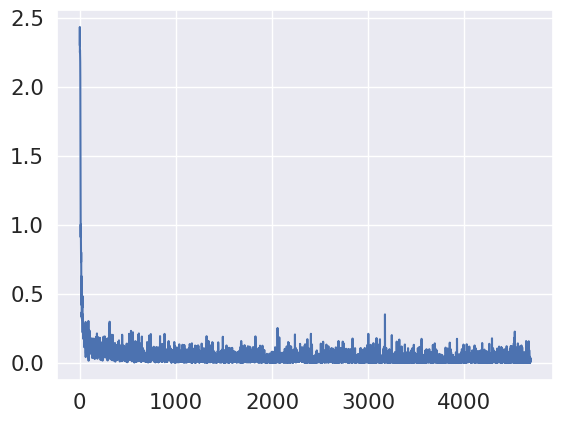

In [ ]:
plt.plot(loss)
plt.show()

# Построим confusion matrix


In [ ]:
y_test = []
y_pred = []
for X_batch, y_batch in tqdm(test_loader):
  with torch.no_grad():
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    outp = model(X_batch)
    y_pred += torch.argmax(outp, dim=1).tolist()
    y_test += y_batch.tolist()

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
cm = confusion_matrix(y_test, y_pred)

<Axes: >

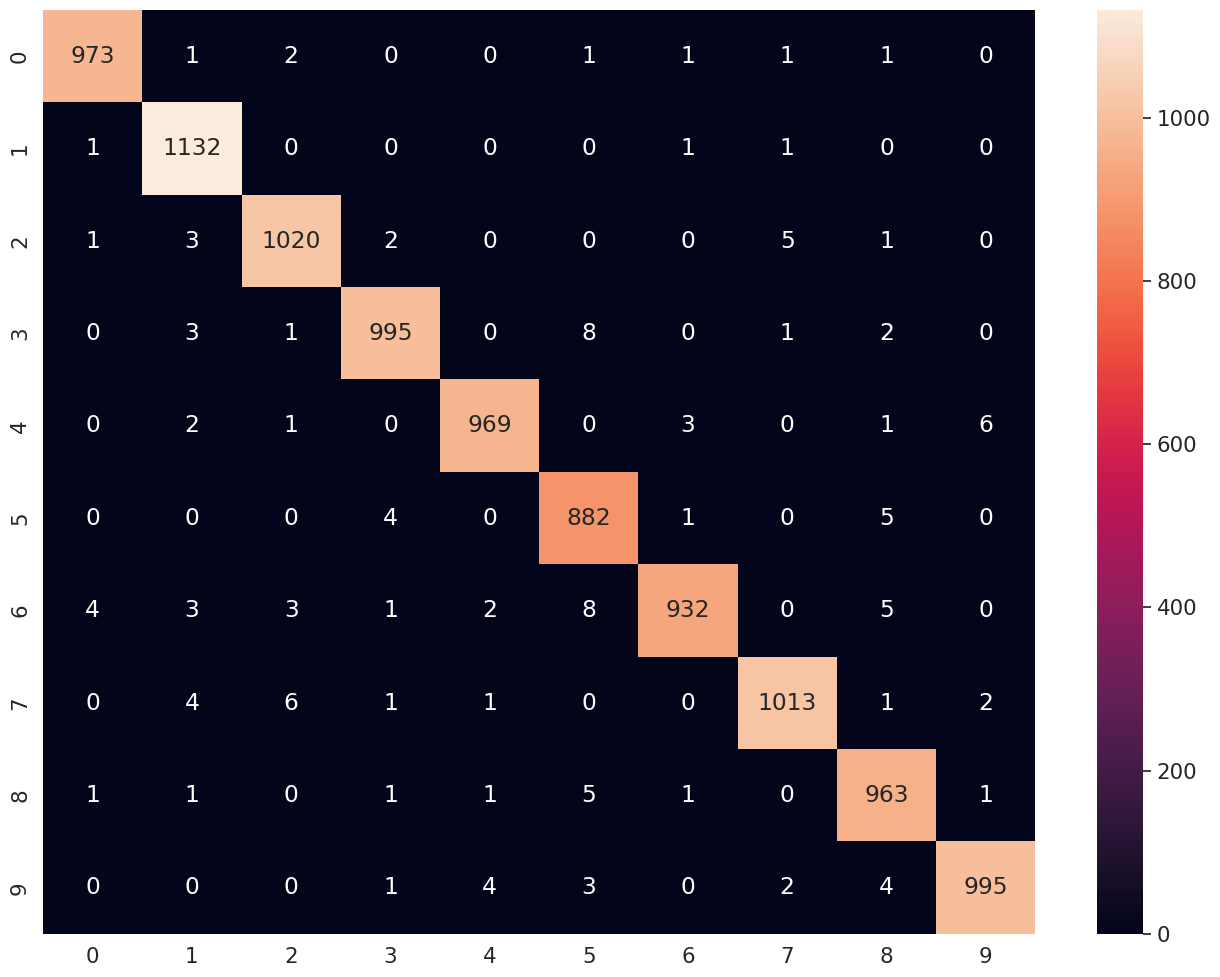

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, fmt="")

# Вывод:
Можно отметить, что в ходе этой работы мы создали довольно неплохую модель, которая предсказывает значения из датасета MNIST на 98%.